In [1]:
import pandas as pd
import os
import dotenv

dotenv.load_dotenv()
DATA_DIR = os.getenv("DATA_DIR", "./data")
SOUP_DIR = os.getenv("SOUP_DIR", ".models/soup_models")

In [2]:
df_soups = pd.read_parquet(os.path.join(SOUP_DIR, "rand_soups_seed_42.parquet"), engine="fastparquet")

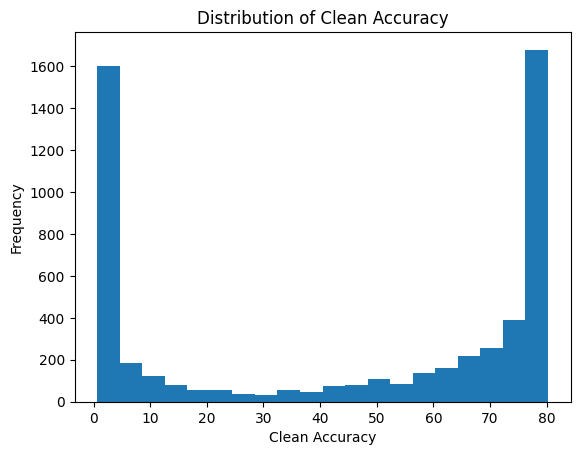

In [3]:
df_soups    

# sort by clean_accuracy
df_soups_sorted = df_soups.sort_values(by="clean_accuracy", ascending=False)
df_soups_sorted

# Plot distribution of clean_accuracy
import matplotlib.pyplot as plt
plt.hist(df_soups["clean_accuracy"], bins=20)
plt.xlabel("Clean Accuracy")
plt.ylabel("Frequency")
plt.title("Distribution of Clean Accuracy")
plt.show()

In [4]:
# find result for key_a = 50_4 and key_b = 50_4
result = df_soups[(df_soups["key_a"] == "100_2")]
result = result[result["key_b"] == "100_4"]
result

,key_a,key_b,branch_epoch_a,branch_epoch_b,model_id_a,model_id_b,clean_accuracy,clean_loss,acc_corr_3,loss_corr_3
4713,100_2,100_4,100,100,2,4,77.84,1.117765,48.832632,2.457333
